In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import warnings
warnings.filterwarnings("ignore")

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from pandas import concat
!pip install prophet
from prophet import Prophet

In [5]:
df=pd.read_csv('AEP_hourly.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [8]:
ts=pd.DataFrame(df['AEP_MW'])

**Indexing with Time Series Data**

In [9]:
ts=ts.set_index(pd.to_datetime(df['Datetime']))
ts.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


**Visualizing Energy Consumption Time Series Data**

<Figure size 1500x1000 with 0 Axes>

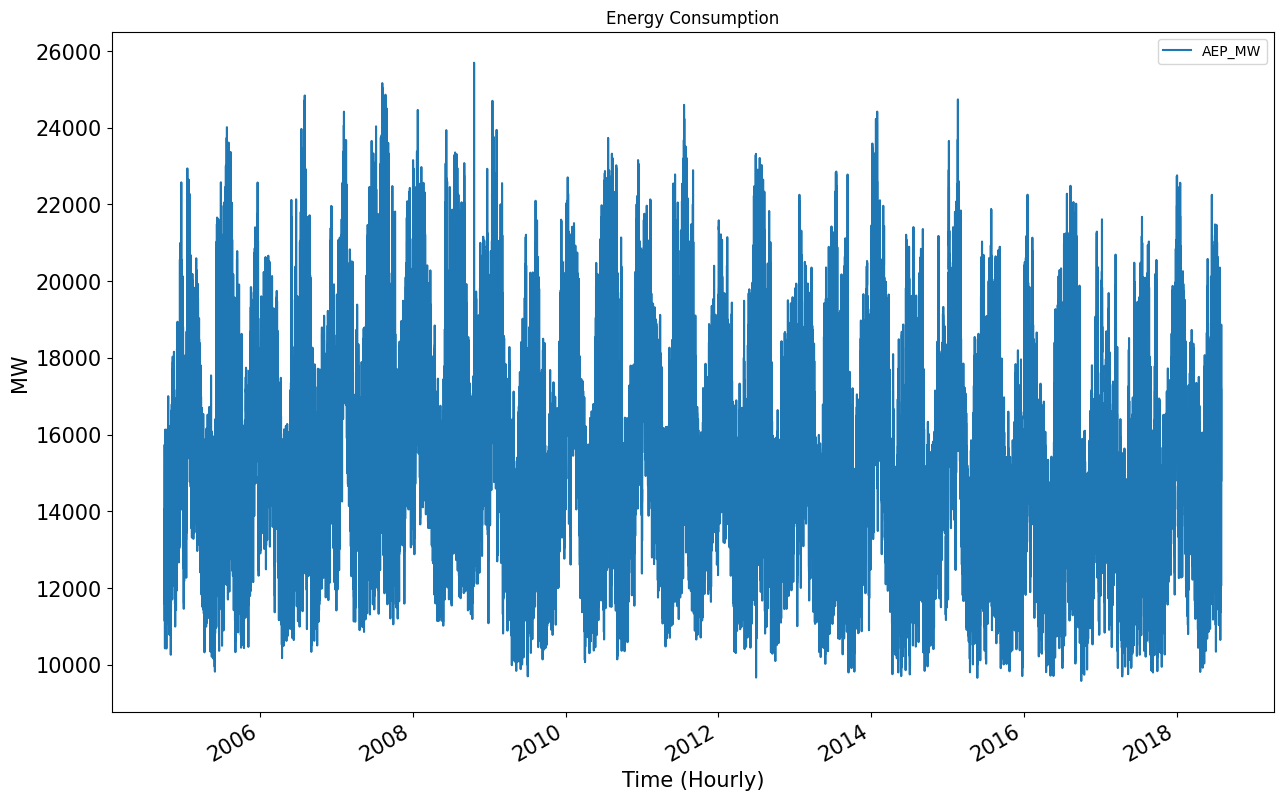

In [10]:
rcParams['figure.figsize'] = 15, 10
fig = plt.figure()
#plt.plot(ts)
ts.plot(fontsize=15)
plt.title('Energy Consumption')
plt.xlabel('Time (Hourly)', fontsize=15)
plt.ylabel('MW', fontsize=15)
plt.show()

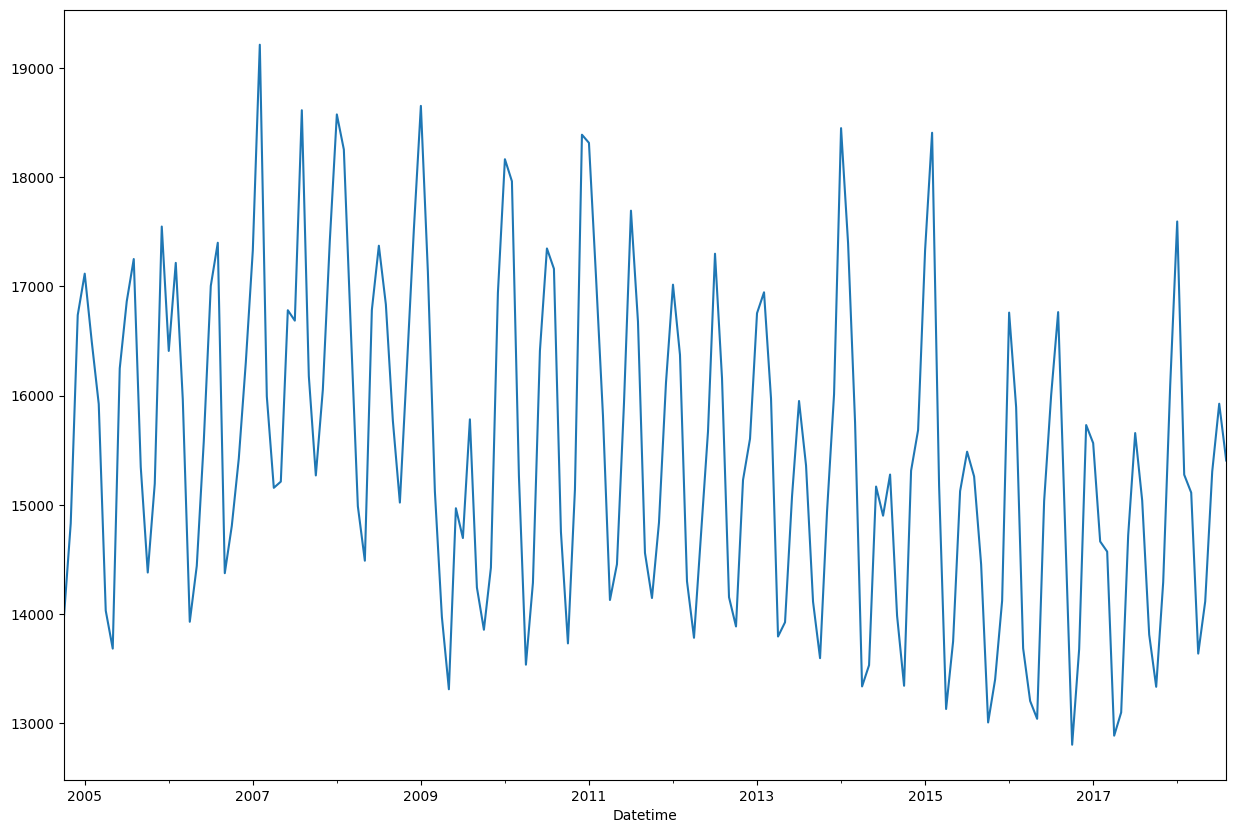

In [11]:
# Converting it to monthly data

y = ts['AEP_MW'].resample('MS').mean()
y.plot()
plt.show()

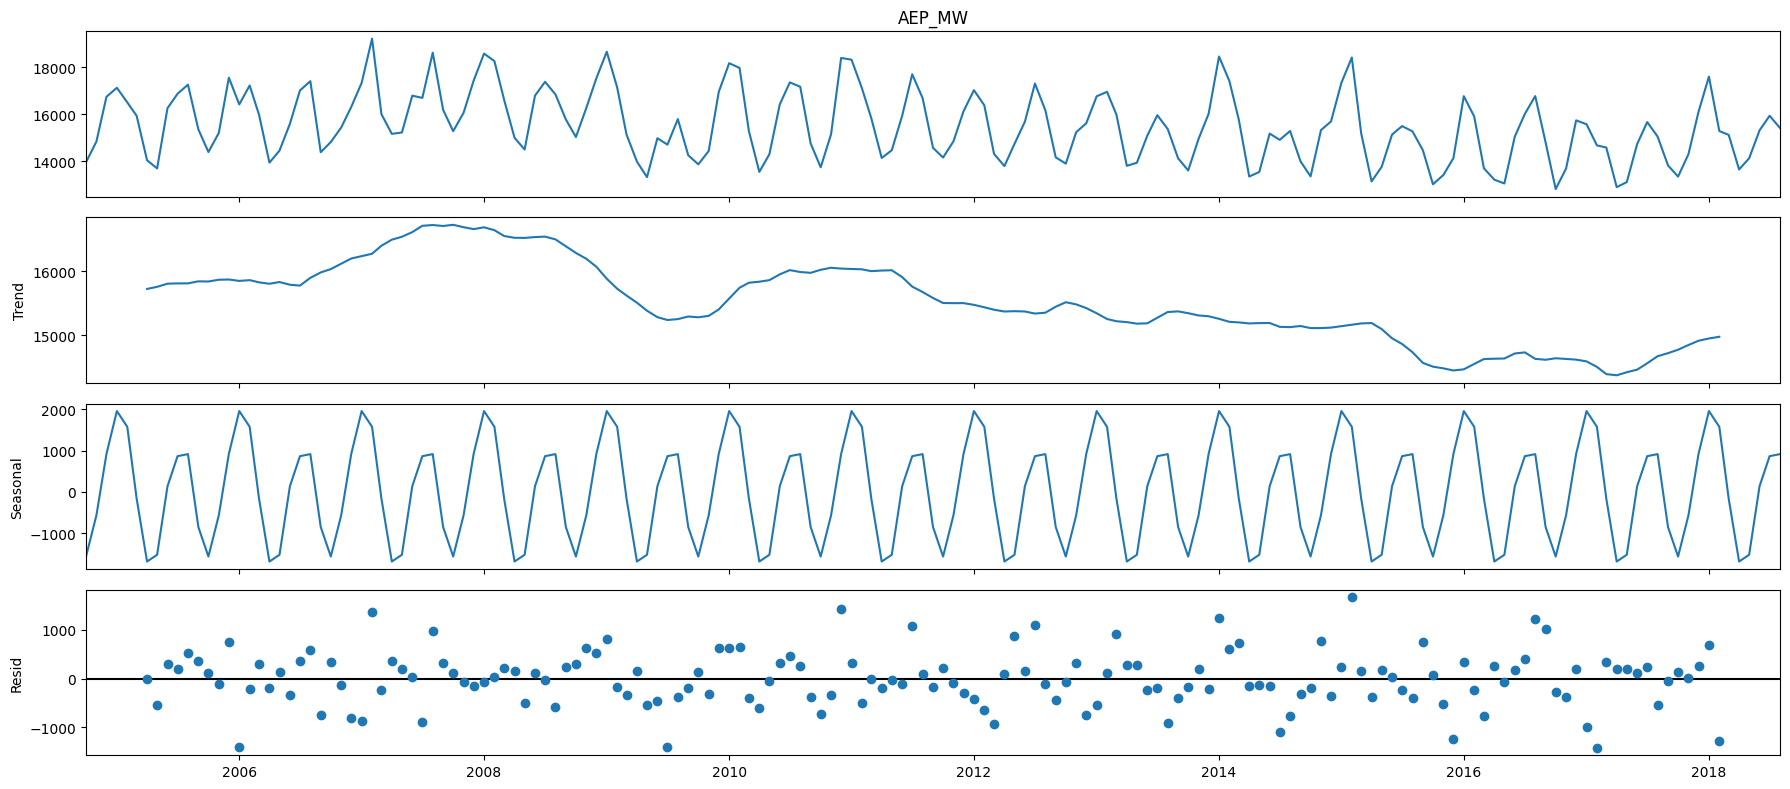

In [12]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [13]:
split_date = '2017-01-01'
y_train = y.loc[y.index < split_date].copy()
y_test = y.loc[y.index >= split_date].copy()

**Using ARIMA**

In [14]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [15]:
opt_pdq=(0,0,0)
opt_PDQ=(0,0,0,0)
opt_AIC=10000

In [16]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            #print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic<opt_AIC:
                opt_pdq=param
                opt_PDQ=param_seasonal
                opt_AIC=results.aic
        except:
            continue

print('Optimal SARIMA Model {}x{} - AIC:{}'.format(opt_pdq, opt_PDQ, opt_AIC))

Optimal SARIMA Model (1, 1, 1)x(1, 1, 1, 12) - AIC:1931.0630422430684


**Fitting an ARIMA time series model**

In [17]:
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=opt_pdq,
                                seasonal_order=opt_PDQ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4412      0.083      5.329      0.000       0.279       0.603
ma.L1         -0.9997      0.148     -6.770      0.000      -1.289      -0.710
ar.S.L12       0.0940      0.054      1.735      0.083      -0.012       0.200
ma.S.L12      -0.7974      0.101     -7.869      0.000      -0.996      -0.599
sigma2      4.598e+05   3.24e-07   1.42e+12      0.000     4.6e+05     4.6e+05


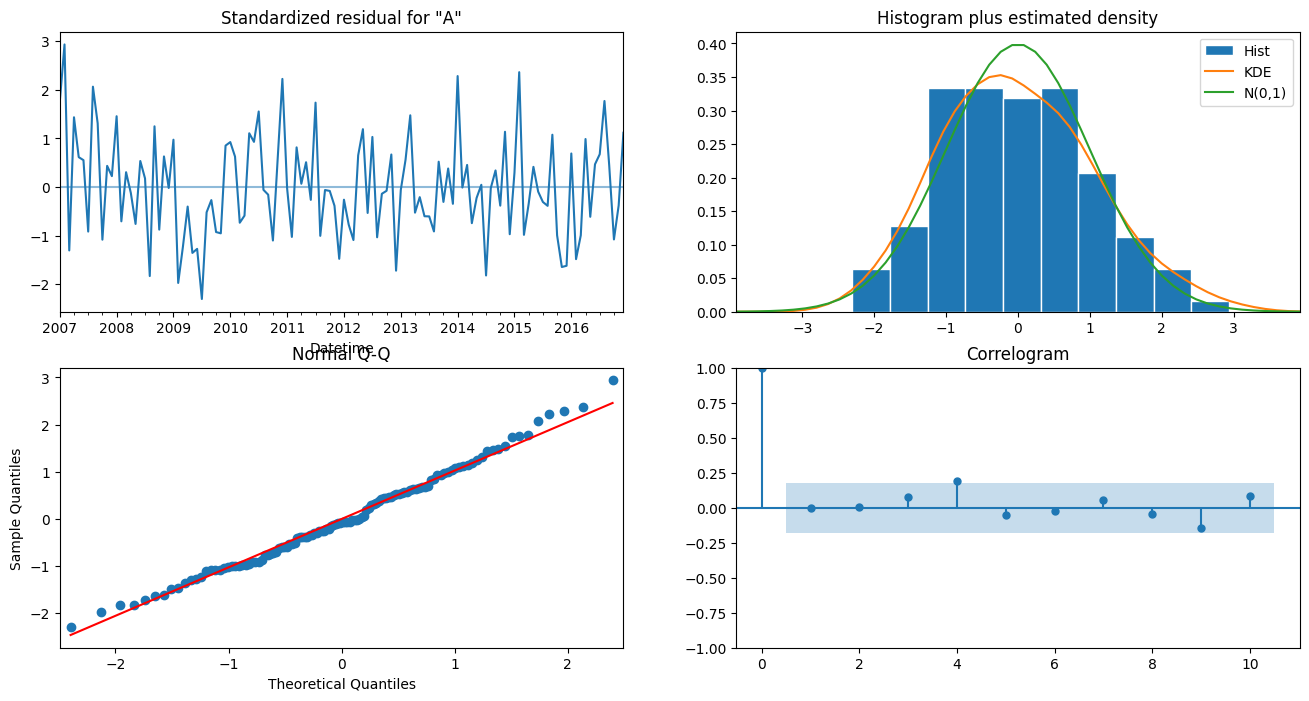

In [18]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

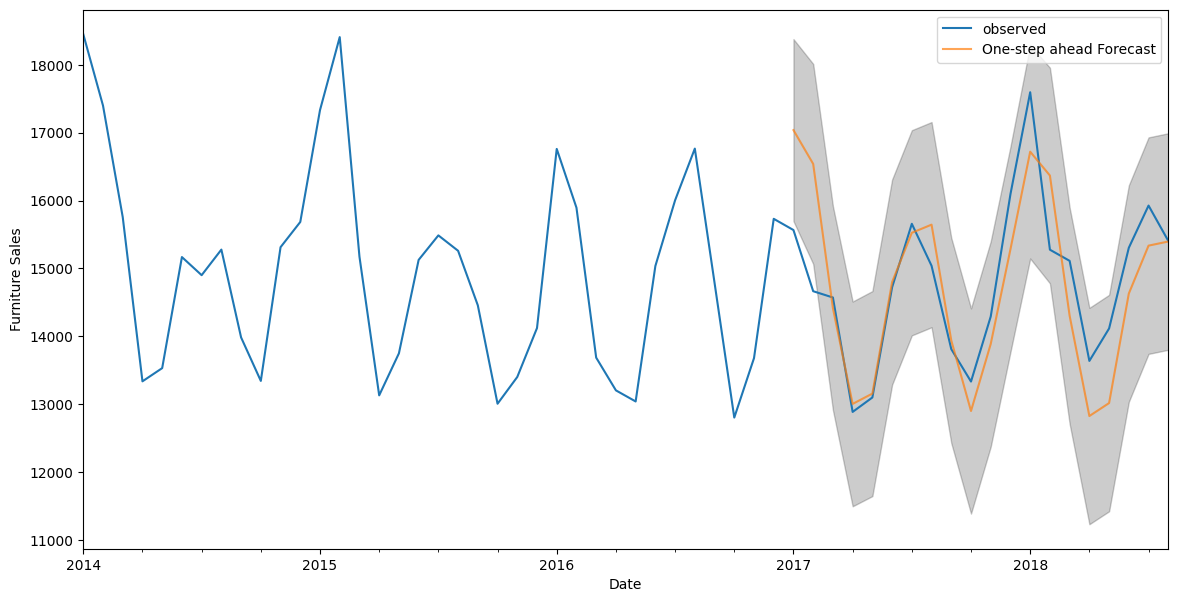

In [19]:
pred = results.get_prediction(start=pd.to_datetime(split_date),
                              end=y.index.max(),
                              dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [20]:
def RMSE(forecast,truth):
    diff=forecast-truth
    RMSE = np.sqrt((diff ** 2).mean())
    print('The Root Mean Squared Error of our forecasts (RMSE) is {}'.format(round(RMSE, 2)))

In [21]:
def MAPE(forecast,truth):
    diff=forecast-truth
    MAPE=abs(diff/truth).mean()*100
    print('The Mean Absolute Percentage Error (MAPE) of our forecasts is {}%'.format(round(MAPE, 2)))

In [22]:
y_forecast = pred.predicted_mean
y_truth=y_test

In [23]:
RMSE(y_forecast,y_truth)

The Root Mean Squared Error of our forecasts (RMSE) is 787.82


In [24]:
MAPE(y_forecast,y_truth)

The Mean Absolute Percentage Error (MAPE) of our forecasts is 4.07%


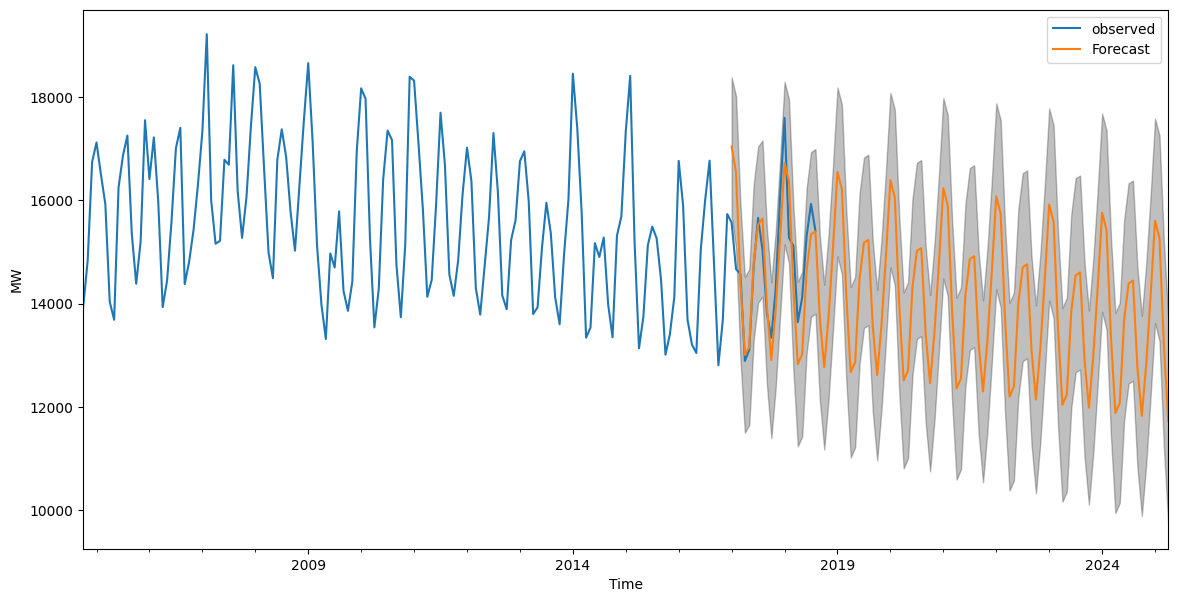

In [25]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time')
ax.set_ylabel('MW')
plt.legend()
plt.show()

**Time Series modelling using Prophet**

In [26]:
y_train_fb=y_train.reset_index()

In [28]:
model = Prophet(interval_width=0.95)
model.fit(y_train_fb.rename(columns={'Datetime':'ds', 'AEP_MW':'y'}))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9r_d0acc/n7z5tw9k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9r_d0acc/watnojta.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36061', 'data', 'file=/tmp/tmp9r_d0acc/n7z5tw9k.json', 'init=/tmp/tmp9r_d0acc/watnojta.json', 'output', 'file=/tmp/tmp9r_d0acc/prophet_modeleq4l0oca/prophet_model-20240830110244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:02:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:02:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [29]:
y_test_fb=y_test.reset_index()

In [31]:
forecast_time=pd.DataFrame(y_test_fb['Datetime'])
forecast_time.columns=['ds']

In [32]:
y_forecast_fb = model.predict(forecast_time)
y_forecast_fb.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,14641.777508,15302.569017,17805.821066,14641.015923,14642.358257,1889.483976,1889.483976,1889.483976,1889.483976,1889.483976,1889.483976,0.0,0.0,0.0,16531.261485


In [34]:
RMSE(y_forecast_fb['yhat'],y_test_fb['AEP_MW'])

The Root Mean Squared Error of our forecasts (RMSE) is 752.98


In [35]:
MAPE(y_forecast_fb['yhat'],y_test_fb['AEP_MW'])

The Mean Absolute Percentage Error (MAPE) of our forecasts is 4.02%


In [36]:
y_forecast_fb.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,14641.777508,15302.569017,17805.821066,14641.015923,14642.358257,1889.483976,1889.483976,1889.483976,1889.483976,1889.483976,1889.483976,0.0,0.0,0.0,16531.261485


In [37]:
df1=pd.DataFrame(y_forecast_fb['yhat'])
df2=df1.set_index(y_forecast_fb['ds'])

In [38]:
df3=pd.DataFrame(y_forecast_fb[['yhat_lower','yhat_upper']])
df4=df3.set_index(y_forecast_fb['ds'])

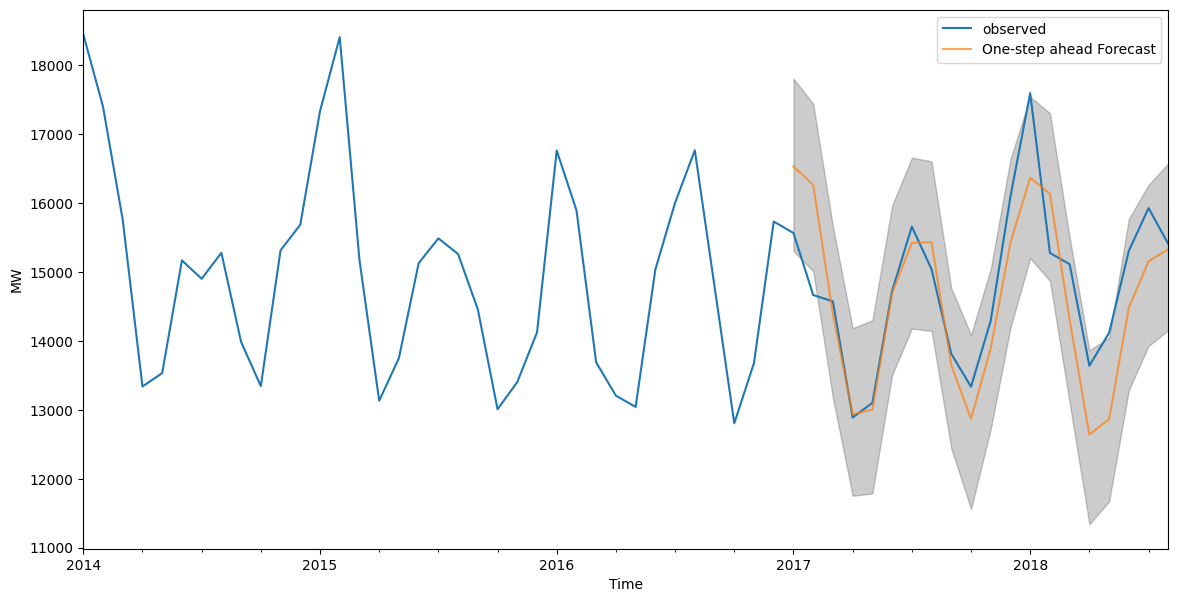

In [39]:
ax = y['2014':].plot(label='observed')
df2.iloc[:,0].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(df4.index,
                df4.iloc[:, 0],
                df4.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Time')
ax.set_ylabel('MW')
plt.legend()
plt.show()

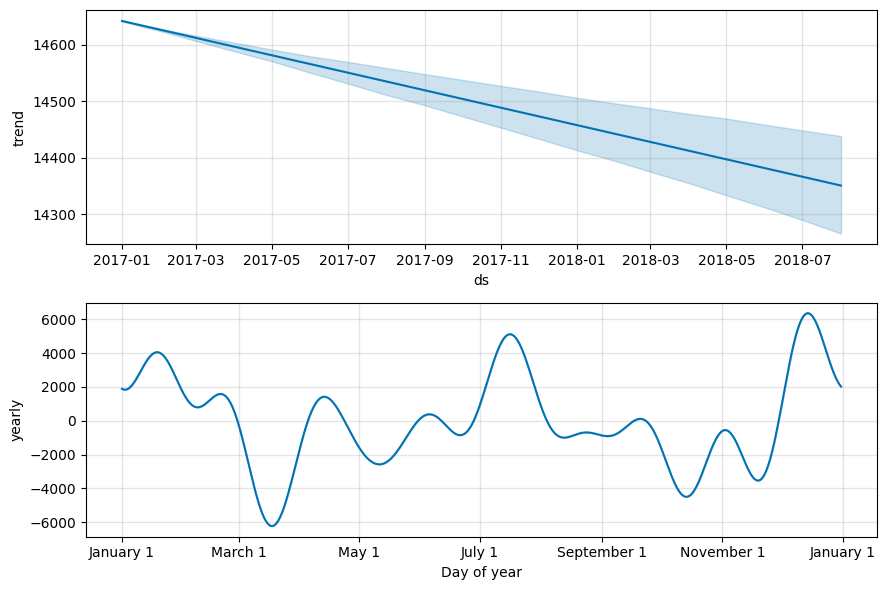

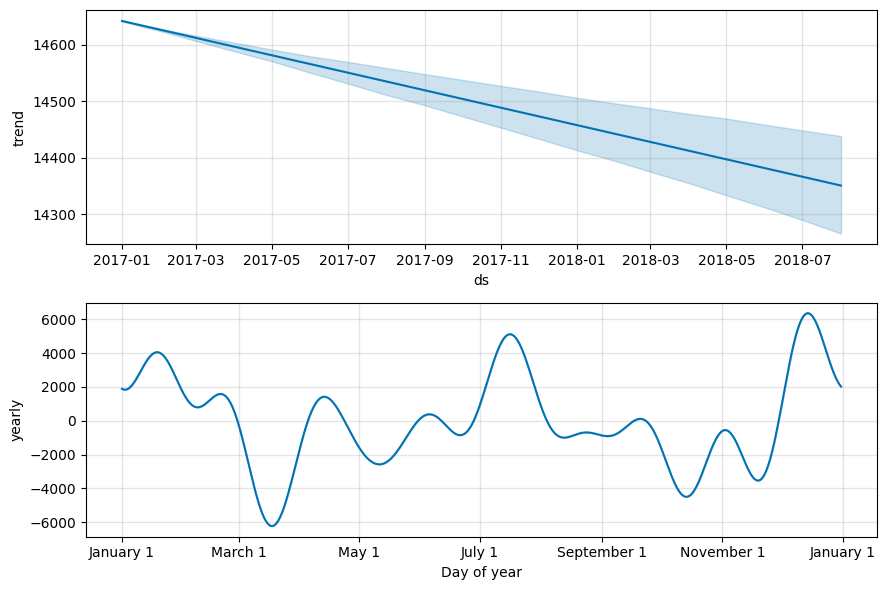

In [40]:
model.plot_components(y_forecast_fb)

**Using LSTM**

In [42]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [43]:
y_train_array=y_train.values

In [44]:
y_train_array.shape

(147,)

In [45]:
n_features = 1
y_train_array = y_train_array.reshape((len(y_train_array), n_features))
y_train_array.shape

(147, 1)

In [46]:
n_input = 6
generator = TimeseriesGenerator(y_train_array, y_train_array, length=n_input, batch_size=len(y_train_array)-n_input)
generator

In [47]:
model_lstm = Sequential()
model_lstm.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

In [49]:
model_lstm.fit(generator, steps_per_epoch=1, epochs=500, verbose=2)

Epoch 1/500
1/1 - 2s - 2s/step - loss: 173226480.0000
Epoch 2/500
1/1 - 0s - 11ms/step - loss: 0.0000e+00
Epoch 3/500
1/1 - 0s - 41ms/step - loss: 165033008.0000
Epoch 4/500
1/1 - 0s - 9ms/step - loss: 0.0000e+00
Epoch 5/500
1/1 - 0s - 45ms/step - loss: 158985456.0000
Epoch 6/500
1/1 - 0s - 8ms/step - loss: 0.0000e+00
Epoch 7/500
1/1 - 0s - 35ms/step - loss: 153681680.0000
Epoch 8/500
1/1 - 0s - 10ms/step - loss: 0.0000e+00
Epoch 9/500
1/1 - 0s - 41ms/step - loss: 148089344.0000
Epoch 10/500
1/1 - 0s - 10ms/step - loss: 0.0000e+00
Epoch 11/500
1/1 - 0s - 39ms/step - loss: 141719440.0000
Epoch 12/500
1/1 - 0s - 8ms/step - loss: 0.0000e+00
Epoch 13/500
1/1 - 0s - 39ms/step - loss: 134006112.0000
Epoch 14/500
1/1 - 0s - 9ms/step - loss: 0.0000e+00
Epoch 15/500
1/1 - 0s - 45ms/step - loss: 127493400.0000
Epoch 16/500
1/1 - 0s - 17ms/step - loss: 0.0000e+00
Epoch 17/500
1/1 - 0s - 108ms/step - loss: 122510200.0000
Epoch 18/500
1/1 - 0s - 9ms/step - loss: 0.0000e+00
Epoch 19/500
1/1 - 0s - 4

In [50]:
pred_lstm=[]
# make a one step prediction out of sample
for i in range(0,len(y_test)):
    x_past=y.values[len(y_train)-n_input+i:len(y_train)+i]
    x_input = x_past.reshape((1, n_input, n_features))
    yhat = model_lstm.predict(x_input, verbose=0)
    pred_lstm.append(yhat[0,0])

In [51]:
RMSE(pred_lstm,y_test.values)

The Root Mean Squared Error of our forecasts (RMSE) is 946.67


In [52]:
MAPE(pred_lstm,y_test.values)

The Mean Absolute Percentage Error (MAPE) of our forecasts is 4.81%


**Using TSFRESH**

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
!pip install tsfresh
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


In [55]:
%load_ext autoreload
%autoreload 2

In [56]:
from tsfresh.utilities.dataframe_functions import roll_time_series

In [57]:
df_shift, ts_y = make_forecasting_frame(y, kind="price", max_timeshift=10, rolling_direction=1)

Rolling: 100%|██████████| 167/167 [00:00<00:00, 234.88it/s]


In [58]:
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 166/166 [00:10<00:00, 15.12it/s]


In [59]:
col_drop=[]
for i in range(len(X.columns)):
    if ((X.iloc[:,i]==0).sum())==len(X):
       col_drop.append(X.columns[i])

In [60]:
for i in col_drop:
    X=X.drop(i,axis=1)

In [77]:
# Extract the date level (assuming it is the first level)
date_index = X.index.get_level_values(1)

# Convert the extracted date level to datetime
date_index = pd.to_datetime(date_index)

# Create a new DatetimeIndex
X.index = pd.MultiIndex.from_arrays([date_index, X.index.get_level_values(1)], names=['date', 'other_level'])


split_date = pd.to_datetime('2017-01-01')
# X.index = X.index.set_levels([date_index, X.index.get_level_values(1)], level=0)
# X.index = pd.to_datetime(X.index)
# ts_y.index = pd.to_datetime(ts_y.index)

x_train = X.loc[X.index.get_level_values(1) < split_date].copy()
x_test = X.loc[X.index.get_level_values(1) >= split_date].copy()

y_train = ts_y.loc[X.index.get_level_values(1) < split_date].copy()
y_test = ts_y.loc[X.index.get_level_values(1) >= split_date].copy()

In [79]:
from sklearn import ensemble
from xgboost import XGBRegressor as xgb
model = xgb()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

In [80]:
y_pred

array([16054.519, 16488.771, 14994.829, 13294.408, 13775.311, 14955.125,
       16052.039, 16074.332, 14538.882, 13640.566, 14185.676, 15982.966,
       16870.096, 17385.207, 14921.935, 13335.657, 13188.14 , 15486.683,
       16042.562, 16669.348], dtype=float32)

In [81]:
y_test.values

array([15566.19758065, 14665.68452381, 14572.87213997, 12888.32777778,
       13100.91532258, 14722.43055556, 15658.10215054, 15040.50268817,
       13812.88472222, 13335.42204301, 14293.22468793, 16094.72849462,
       17594.875     , 15276.66369048, 15112.57873486, 13639.24444444,
       14117.00537634, 15305.25      , 15926.62231183, 15406.95918367])

In [82]:
RMSE(y_pred,y_test.values)

The Root Mean Squared Error of our forecasts (RMSE) is 833.21


In [83]:
MAPE(y_pred,y_test.values)

The Mean Absolute Percentage Error (MAPE) of our forecasts is 4.24%


In [85]:
ts=ts.set_index(pd.to_datetime(df['Datetime']))
ts.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [86]:
y_pred=pd.DataFrame(y_pred)

In [87]:
y_pred=y_pred.set_index(y_test.index)

In [90]:
print(type(y))       # Should be a list, numpy array, or pandas Series
print(type(y_pred))  # Should be a list, numpy array, or pandas Series

print(y[:10])        # Inspect the first few values
print(y_pred[:10])   # Inspect the first few values


<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
Datetime
2004-10-01    13947.537736
2004-11-01    14830.440278
2004-12-01    16737.720430
2005-01-01    17117.088710
2005-02-01    16496.644345
2005-03-01    15924.061828
2005-04-01    14032.422809
2005-05-01    13685.072581
2005-06-01    16250.333333
2005-07-01    16863.873656
Freq: MS, Name: AEP_MW, dtype: float64
                                      0
(id, 2017-01-01 00:00:00)  16054.518555
(id, 2017-02-01 00:00:00)  16488.771484
(id, 2017-03-01 00:00:00)  14994.829102
(id, 2017-04-01 00:00:00)  13294.408203
(id, 2017-05-01 00:00:00)  13775.310547
(id, 2017-06-01 00:00:00)  14955.125000
(id, 2017-07-01 00:00:00)  16052.039062
(id, 2017-08-01 00:00:00)  16074.332031
(id, 2017-09-01 00:00:00)  14538.881836
(id, 2017-10-01 00:00:00)  13640.566406
